In [95]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import DBSCAN

%matplotlib inline

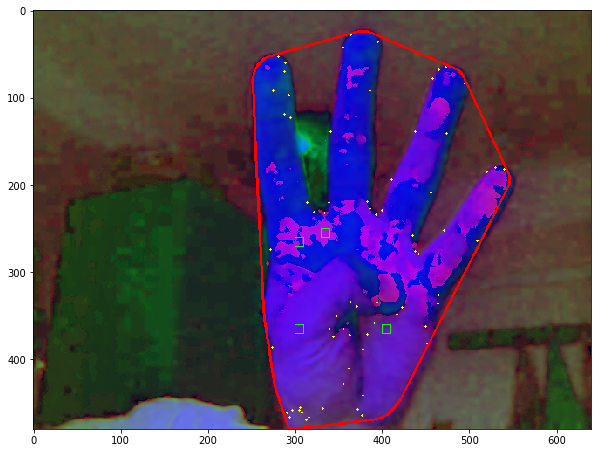

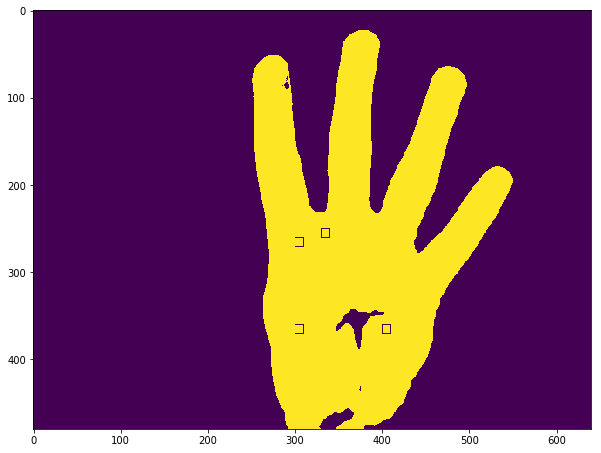

CPU times: user 1.77 s, sys: 366 ms, total: 2.13 s
Wall time: 2 s


In [103]:
%%time

image = './memage2.jpg'
kernel = np.ones((3,3),np.uint8)
image = cv2.imread(image)
image2 = image.copy()

image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower = np.array([0, 0, 130])
upper = np.array([255, 60, 255])
mask = cv2.GaussianBlur(image, (5, 5), 100)
mask = cv2.inRange(mask, lower, upper)


frame3 = image[330:340,250:260]
cv2.rectangle(image,(330,250),(340,260),(0,255,0))
frame4 = image[300:310,260:270]
cv2.rectangle(image,(300 ,260), (310, 270),(0,255,0))
frame5 = image[300:310,360:370]
cv2.rectangle(image,(300 ,360), (310, 370),(0,255,0))
frame6 = image[400:410,360:370]
cv2.rectangle(image,(400 ,360), (410, 370),(0,255,0))
# hsv ranges for hand skin


contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_contour = max(contours,key=lambda x: cv2.contourArea(x))
cnt = contours[0] # delete excess dim for list
max_hull = cv2.convexHull(max_contour)
epsilon = 0.001*cv2.arcLength(max_contour,True)
approx= cv2.approxPolyDP(max_contour,epsilon,True)

lower_skin = np.array([0,0,100], dtype=np.uint8)
upper_skin = np.array([255,80,255], dtype=np.uint8)
mask = cv2.inRange(image, lower_skin, upper_skin)

leftmost = max_hull[max_hull[:,:,0].argmin()][0]
rightmost = max_hull[max_hull[:,:,0].argmax()][0]
delta = np.linalg.norm(leftmost-rightmost) // 8

center = np.mean(max_hull, axis=0,dtype=np.uint32)
cx, cy = tuple(center[0])
cy += 50
final = cv2.drawContours(image, approx, -1,(255,255,0), 2)

final = cv2.drawContours(image, [max_hull], -1,(255,0,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(final) #cmap='gray', interpolation='nearest')
plt.figure(figsize=(10,10))
plt.imshow(mask)

plt.show()

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 142 ms


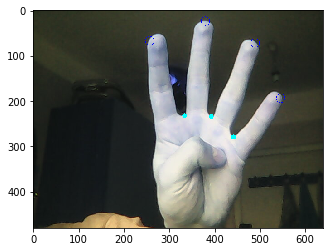

In [105]:
%%time


def check_for_maxhull(point, max_hull,measure):
    for index in range(len(max_hull)-1):
        if per_distance(max_hull[index],max_hull[index+1],point) < measure:
            return False
    return True

def per_distance(lp1, lp2, p):
    return np.linalg.norm(np.cross(lp2-lp1, lp1-p))/np.linalg.norm(lp2-lp1)

image3 = image2.copy()
real_points = []

distance = lambda i, j: np.linalg.norm(i-j)
vect_dist = np.vectorize(distance)

data = np.array(np.squeeze(approx,axis=1))[:,1]
indexes, _ = peakdet(data,.2)
if indexes.size > 0:
        real_points = []
        corner_points = np.take(np.array(np.squeeze(approx,axis=1)), indexes[:,0],axis=0)
        for point in corner_points:
            if check_for_maxhull(point,max_hull,20) is True and point[1]<cy:
                cv2.circle(image3, tuple(point), 5, (0, 255, 255),-1)
                real_points.append(tuple(point))

max_hull_top = np.array([i[0] for i in max_hull if i[0][1] < cy])
clustering = DBSCAN(eps=14, min_samples=1).fit(max_hull_top)
labels = clustering.labels_
means = []
for i in np.unique(labels):
    if i >= 0 and np.count_nonzero(labels==i) >= 2:
        array = []
        for num, j in enumerate(labels):
            if j == i:
                array.append(max_hull_top[num])
        if array != []:
            ax,ay = tuple(np.squeeze(np.mean(np.array(array),axis=0)))
            cv2.circle(image3,(int(ax),int(ay)) ,10, (0,0,255), 1)
            means.append((int(ax),int(ay)))
plt.imshow(image3)

In [108]:
def get_neighb(elem, narray):
    elem = elem.tolist()
    array = narray.copy()
    array.append(elem)
    array = sorted(array, key=lambda x:x[0])
    index = array.index(elem)
    
    if index > 0 and index != len(array)-1:
        return np.array([array[index-1], array[index+1]])
    else:
        return np.array(np.zeros((2,)))

def get_angle(p1, p2, p3):
    line1 = p2 - p1
    line2 = p3 - p1
    cosine = np.dot(line1, line2) / (np.linalg.norm(line1) * np.linalg.norm(line2))
    angle = np.arccos(cosine)
    print(angle * 180 / np.pi)
    return angle * 180 / np.pi

In [426]:
point = np.array([1,2])
angle(point, np.zeros(point.shape), np.zeros(point.shape))

1.2074182697257333e-06

37.48735519976892
34.45407797516841
37.6853594151553


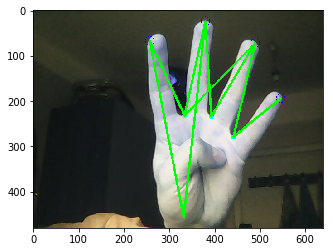

In [110]:
def find_nearest(means, roots, image):
    means = sorted(means,key=lambda x:x[0])
    roots = sorted(roots,key=lambda x:x[0])
    means = np.array(means)
    roots = np.array(roots)
    for i in range(len(means)-1):
        angle = get_angle(roots[i],means[i],means[i+1])
        if angle > 10 and angle < 70:
            cv2.line(image, tuple(roots[i]), tuple(means[i+1]), (0,255,0),4)
            cv2.line(image, tuple(roots[i]), tuple(means[i]), (0,255,0),4)
    plt.imshow(image3)
find_nearest(means,real_points,image3)

35.293667535970634
36.63957038329857
41.366539417977926


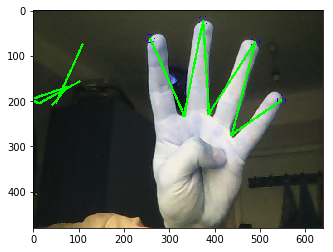

In [631]:
find_nearest(means,imp_points,image3)
#plt.imshow(image3)

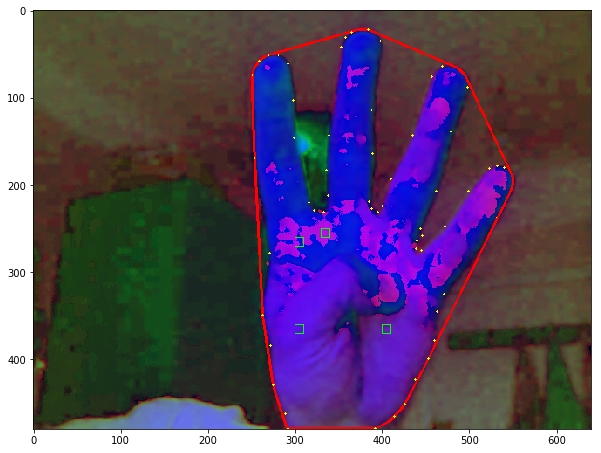

In [800]:
final2 = image2.copy()
final2 = cv2.drawContours(final, np.expand_dims(approx[:30],axis=1), -1,(255,255,0), 2)
plt.figure(figsize=(10,10))
plt.imshow(final2)

dtype('uint8')

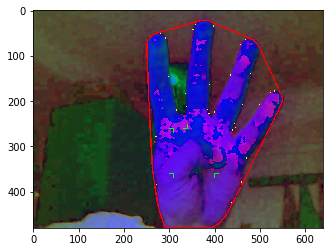

In [20]:
plt.imshow(final)
checkpoint = approx[0]
max_hull.shape
final.dtype

In [26]:
def check_near_maxhull(point, image, measure):
    
    
check_near_maxhull(checkpoint,final)

2425675


In [14]:
def peakdet(v, delta, x=None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)


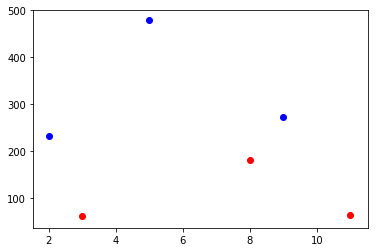

In [900]:
data = np.squeeze(approx,axis=1)
data = data[:,1]
maxtab, mintab = peakdet(data,.01)
scatter(array(maxtab)[:,0], array(maxtab)[:,1], color='blue')
scatter(array(mintab)[:,0], array(mintab)[:,1], color='red')

In [901]:
for i in np.take(imp_points, min_tab[:,0],axis=0):
    print(tuple(i))

(298, 103)
(499, 207)
(479, 139)


In [94]:
data = np.array(np.squeeze(approx,axis=1))[:,1]
# data = np.arange(len(imp_points)-1)
_, indexes = peakdet(data,.2)
indexes=np.empty([])
print(indexes)
if indexes.size>0:
    points = np.take(np.array(approx), indexes[:,0],axis=0)

36.2


IndexError: too many indices for array

In [961]:
dist = lambda i,j: np.linalg.norm(i-j)

In [962]:
npv = np.vectorize(dist)

In [968]:
distances = np.sqrt(np.sum(npv(np.squeeze(max_hull,axis=1), np.squeeze(max_hull,axis=1)[0])**2,axis=1))

In [8]:
def peakdet(v, delta, x=None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)



In [114]:
image.shape

(480, 640, 3)

In [38]:
def per_distance(lp1, lp2, p):
    return np.linalg.norm(np.cross(lp2-lp1, lp1-p))/np.linalg.norm(lp2-lp1)
per_distance(p1,p2,p3)

1.0

In [67]:

def find_root_points(max_hull,imp_points,measure):
    result_point = []
    for index in range(len(max_hull)-1):    
        for point in imp_points:
            if per_distance(max_hull[index],max_hull[index+1],point) < measure:
                continue
            elif point not in result_point:
                # print(per_distance(max_hull[index],max_hull[index+1],point))
                result_point.append(point)
    return result_point

def check_near_maxhull(point, max_hull,measure):
    for index in range(len(max_hull)-1):
        if per_distance(max_hull[index],max_hull[index+1],point) < measure:
            return False
    return True

print(find_root_points(max_hull,list(np.squeeze(approx,axis=1)),80))

int32
int32


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()